In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfm = tf.math

In [2]:
# import library functions from repo
import sys, os
sys.path.append('../')

# Prepare Toy Data

In [3]:
# Number of datapoints to generate
N = 3000

In [15]:
# Generate Data
from data import gen_8gaussians
data = gen_8gaussians(batch_size=N)

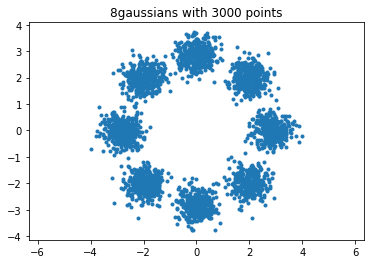

In [5]:
# Inspect the data
plt.plot(data[:, 0], data[:, 1], '.')
plt.axis('equal')
plt.title(f'8gaussians with {N} points')
plt.show()

In [6]:
# Convert the data to a TF dataset
batch_size = 500
dataset = tf.data.Dataset.from_tensor_slices((data)).shuffle(10000).batch(batch_size)

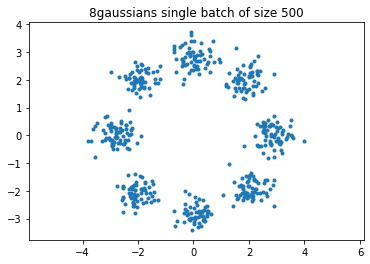

In [7]:
# Plot a single batch of this dataset
single_batch = list(dataset)[0]
plt.plot(single_batch[:, 0], single_batch[:, 1], '.')
plt.axis('equal')
plt.title(f'8gaussians single batch of size {batch_size}')
plt.show()

# Define cluster distributions

In [8]:
def create_cluster_distributions(means, covs, nc, nf, gpd):
  clusters = []
  for i in range(nc):
    dim_mixtures = []
    for j in range(nf):
      components = []
      for k in range(gpd):
        components.append(
          tfd.Normal(
            means[k][i][j], 
            np.sqrt(covs[k][i][j])
          )
        )
      # Add components to the jth dimension mixture
      dim_mixtures.append(
        tfd.Mixture(
          cat=tfd.Categorical(probs=[1/gpd]*gpd),
          components=components,
        )
      )
    clusters.append(tfd.Blockwise(dim_mixtures))

  return clusters

# Initialize Means and Covariances for the distributions

In [9]:
# Set parameters
N_CLUSTERS = 8              # Number of cluster
GPD = 6                     # gauss per dimension in each cluster distribtuion 
N_FEATURES = data.shape[1]  # the dimensions

In [10]:
# Use Kmeans to get initial guess of mu
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0).fit(data)
mu_nd = kmeans.cluster_centers_

# use same means for each gauss in same cluster
mu = []
for i in range(GPD):
  mu.append(mu_nd)
mu = np.array(mu)

In [11]:
# Create cov matrix 
covs_nd = np.full(
    (N_CLUSTERS, N_FEATURES),
    np.diag(
        np.cov(data, rowvar=False)
    )
).astype(np.float32)

# same as for means
covs = []
for i in range(GPD):
  covs.append(covs_nd)
covs = np.array(covs)

# Fit distributions to data

In [21]:
# Number of epochs to run the loop
epochs = 25

In [24]:
# training loop
pi = 1/N_CLUSTERS * np.ones((N_CLUSTERS))
for epoch in range(epochs):

    clusters = create_cluster_distributions(mu, covs, N_CLUSTERS, N_FEATURES, GPD)

    # total responsibility assigned to each cluster 
    r = np.zeros((N, N_CLUSTERS))
    for i in range(N_CLUSTERS):
        r[:,i] = pi[i]*clusters[i].prob(data).numpy()
    r = r / r.sum(axis=1,keepdims=1)  

    # total responsibility assigned to each cluster
    cluster_weights = r.sum(axis = 0)

    # Update prior
    pi = cluster_weights / N

    # update means
    weighted_sum = np.dot(r.T, data)
    for k in range(GPD):
      mu[k] = (weighted_sum / cluster_weights.reshape(-1, 1)).astype(np.float32)

    # Compute covariances
    for i in range(N_CLUSTERS):
      for k in range(GPD):
        diff = (data - mu[k][i]).T
        weighted_sum = np.dot(r[:, i] * diff, diff.T)
        covs[k][i] = np.diag(weighted_sum / cluster_weights[i])

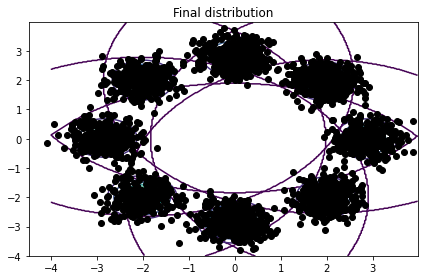

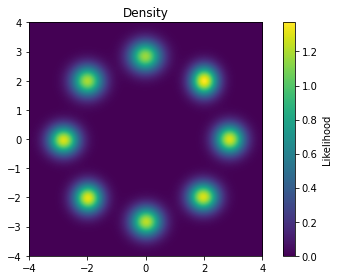

In [26]:
from utils import plot_contours, plot_density
plot_contours(data, clusters, 4,'Final distribution', N_CLUSTERS)
plot_density(clusters, 4,'Density', N_CLUSTERS)